In [27]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.externals import joblib
import json
from scipy.ndimage.measurements import label
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
filename = 'classifier.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))
filename = 'lesson_functions.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))

# Choosing the classifier

I'm using a predictor that had a relatively good test accuracy.

In [29]:
# Choose one of the classifiers that we built in part 1
predictor = get_predictor(8)
predictor.config

{'cell_per_block': 2,
 'color_space': 'HLS',
 'hist_bins': 16,
 'hist_feat': True,
 'hog_channel': 'ALL',
 'hog_feat': True,
 'orient': 9,
 'pix_per_cell': 8,
 'spatial_feat': True,
 'spatial_size': [16, 16],
 'test_accuracy': 0.9893,
 'version': 8}

In [30]:
# #[40,60,80,100,120

In [31]:
project_video_output = 'output_videos/temp.mp4'
clip1 = VideoFileClip("input_videos/project_video.mp4")

In [32]:
filename = 'lesson_functions.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))
FNUM = 0
NUM_FRAMES_PER_PROCESS = 1
MEMORY_LENGTH_FRAMES = 7
memory = []
bbox_history = []
heatmap_history = []
def process_memory(new_data):
    memory.append(new_data)
    if len(memory) > MEMORY_LENGTH_FRAMES:
        memory.pop(0)
def process_bbox_memory(new_data):
    bbox_history.append(new_data)
    if len(bbox_history) > MEMORY_LENGTH_FRAMES:
        bbox_history.pop(0)

def process_heatmap_memory(new_data):
    heatmap_history.append(new_data)
    if len(heatmap_history) > MEMORY_LENGTH_FRAMES:
        heatmap_history.pop(0)


In [33]:
def is_range_overlapping(r1, r2):
    min_r2 = min(r2)
    max_r2 = max(r2)
    if (r1[0] >= min_r2 and r1[0] <= max_r2) or (r1[1] >= min_r2 and r1[1] <= max_r2):
        return True
    return False
        
def are_boxes_overlapping(box1, box2):
    ax1_overlap = is_range_overlapping([box1[0][0], box1[1][0]],  [box2[0][0], box2[1][0]])
    ax2_overlap = is_range_overlapping([box1[0][1], box1[1][1]],  [box2[0][1], box2[1][1]])
    return ax1_overlap and ax2_overlap
    
    

In [41]:
PROCESSING_FREQ = 3
valid_bboxes = []
def process_frame_fast(image, single_image=False, single_image_return_type=None):
    global valid_bboxes
    global FNUM
    FNUM = FNUM + 1
    image_to_draw2 = np.copy(image)
    image_to_draw1 = np.copy(image)
    current_windows = []
    
    if FNUM % PROCESSING_FREQ == 0 or single_image:
        current_windows = current_windows + find_cars(image, predictor, scale=1.5, overlap=0.5)
        current_windows = current_windows + find_cars(image, predictor, scale=1, overlap=0.7)
        hot_windows = current_windows
        current_heat = np.zeros_like(image[:,:,0]).astype(np.float)
        current_heat = add_heat(current_heat,hot_windows)
        
        overlapping_windows = []
        for w in current_windows:
            for b in valid_bboxes:
                if are_boxes_overlapping(b, w):
                    current_heat = add_heat(current_heat,[w], 1)
        
        process_heatmap_memory(current_heat)
        
    # To debug single images ..
    if single_image:
        window_img = draw_boxes(image_to_draw1, hot_windows, color=(0, 0, 255), thick=6)  
        heat = apply_threshold(current_heat, 2.5)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img, valid_bboxes = draw_labeled_bboxes(image_to_draw2, labels)
        if single_image_return_type == 'boxes':
            return window_img
        if single_image_return_type == 'heatmap':
            return current_heat
        if single_image_return_type == 'thresholded_heatmap':
            return heatmap
        else:
            return draw_img

    # This is used for the videos ..
    if len(heatmap_history):
        trailing_heatmap = np.array(heatmap_history).sum(axis=0)
        heat = apply_threshold(trailing_heatmap, MEMORY_LENGTH_FRAMES * 2.5)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)

        # Update with memory info
        draw_img, valid_bboxes = draw_labeled_bboxes(image_to_draw2, labels)
        return draw_img
    else:
        return image_to_draw2

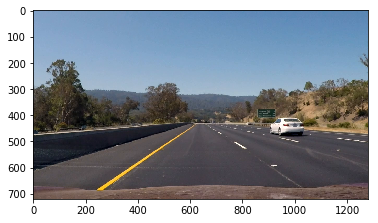

In [42]:
clip1 = VideoFileClip("input_videos/project_video.mp4")
bbox_history = []
img = clip1.get_frame(18)
plt.imshow(img)

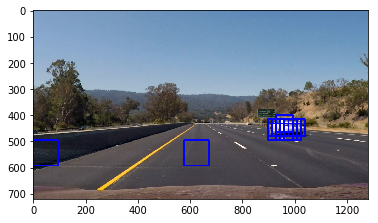

In [48]:
plt.imshow(process_frame_fast(img,single_image=True, single_image_return_type='boxes'))

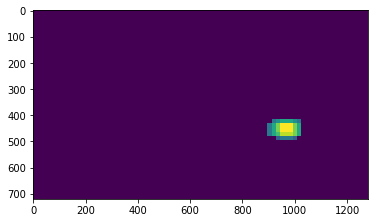

In [49]:
valid_bboxes = [((912, 416), (1023, 495))]
plt.imshow(process_frame_fast(img,single_image=True, single_image_return_type='heatmap'))

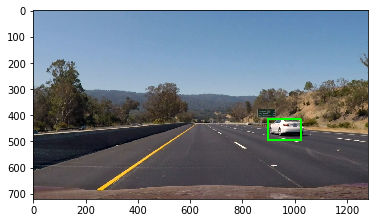

In [44]:
valid_bboxes = [((912, 416), (1023, 495))]
plt.imshow(process_frame_fast(img,single_image=True, single_image_return_type=None))

In [45]:
clip1 = VideoFileClip("input_videos/project_video.mp4")

In [46]:
heatmap_history = []
valid_bboxes = []
MEMORY_LENGTH_FRAMES = 12
clip1 = VideoFileClip("input_videos/project_video.mp4")
#clip1 = clip1.subclip(40, 45)
processed_clip = clip1.fl_image(process_frame_fast) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output_videos/temp.mp4
[MoviePy] Writing video output_videos/temp.mp4


100%|█████████▉| 1260/1261 [10:31<00:00,  1.82it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/temp.mp4 

CPU times: user 8min 34s, sys: 57.5 s, total: 9min 31s
Wall time: 10min 33s


In [47]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('output_videos/temp.mp4'))